In [2]:
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, color
from skimage.transform import resize
import math


In [95]:
img_dir = "./data/downloaded/ericcahan/Alamar, Ciudad De La Habana, Cuba - Sunset 8:11pm.jpg"

# img_dir = "./data/Lenna.png"

In [96]:
def get_df_rgb(img):
    image = img
    if isinstance(img, str):
        image = Image.open(img)
    
    n_dims = np.array(image).shape[-1]
    pixel_values = np.array(image).reshape(-1, n_dims)
    
    # Convert normalized values to 0-255 range if necessary
    if pixel_values.max() <= 1.0:
        pixel_values *= 255
    
    r, g, b = pixel_values.T
    return pd.DataFrame({'r': r, 'g': g, 'b': b})

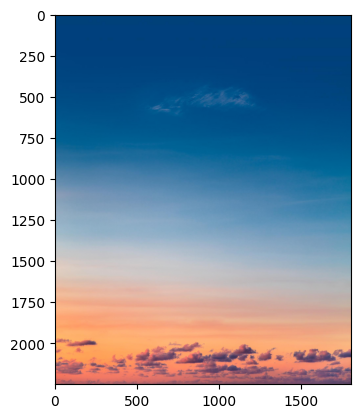

(4050000, 3)


In [97]:
File_name = mpimg.imread(img_dir)
plt.imshow(File_name)
plt.show()

# plt.imshow(image)
# image.show()
rgb_values = get_df_rgb(File_name)
print(rgb_values.shape)

In [98]:
rgb_array = rgb_values.values

# Initialize the PCA model with 2 components
pca = PCA(n_components=2)

# Fit the PCA model to your data
pca.fit(rgb_array)

# Transform the RGB values to the first two principal components
pca_components = pca.transform(rgb_array)


In [99]:
rgb_values.head()

,r,g,b
0,0,65,121
1,0,65,121
2,0,65,121
3,0,65,121
4,0,65,121


In [100]:
np.min(rgb_array, axis=0)

array([ 0, 44, 74], dtype=uint8)

Sort rgb values according to pca_1 value

In [101]:
print(pca_components)

[[-116.85563341   22.63163466]
 [-116.85563341   22.63163466]
 [-116.85563341   22.63163466]
 ...
 [ -34.68463439   67.74377633]
 [ -34.68463439   67.74377633]
 [ -31.89078124   65.71028095]]


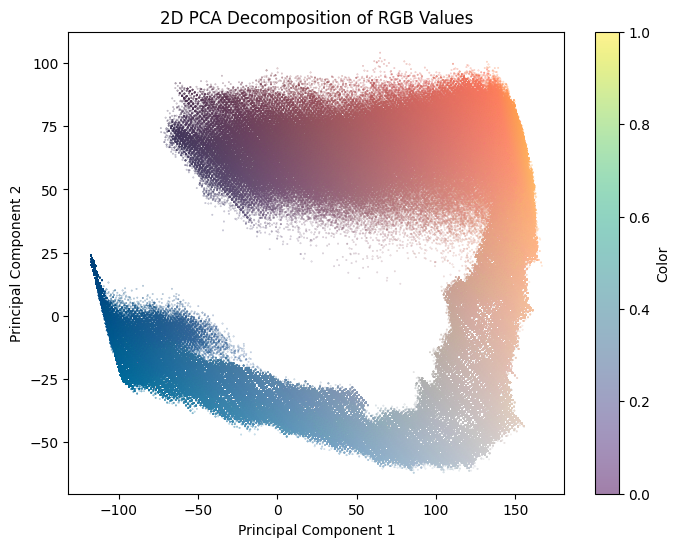

In [109]:
# Create a DataFrame for the transformed PCA components
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])

# Plot the 2D PCA decomposition with colored points
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=rgb_array/255.0, alpha=0.5, s=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Decomposition of RGB Values')
plt.colorbar(label='Color')
plt.show()

In [103]:
center_pos = np.mean(pca_components, axis=0)

print(center_pos)

[-1.54439884e-10 -2.46975348e-11]


In [104]:
min_pc1_index = np.argmin(pca_components[:,0])
min_pc1 = np.min(pca_components[:,0])
print(min_pc1)
print(min_pc1_index)

print(pca_components[min_pc1_index,0])

-117.41512578128479
461928
-117.41512578128479


/var/folders/9l/npp_6cfd1_3ff1p57ff14rfh0000gn/T/ipykernel_3309/480116459.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  segment_colors = plt.cm.get_cmap('tab20', num_segments)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


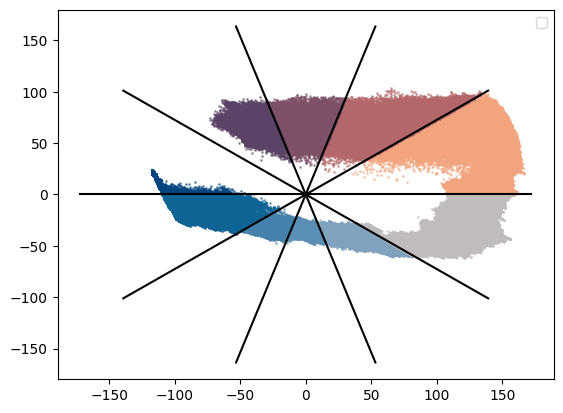

In [114]:
# Using simple mean
# Calculate center
center = np.mean(pca_components, axis=0)

closet_index = np.argmin(np.linalg.norm(pca_components - center, axis=1))

center_color = rgb_array[closet_index]

# Calculate angles (starting from x axis)
angles = np.arctan2(pca_components[:,1] - center[1], pca_components[:,0] - center[0])
angles = np.mod(angles, 2 * np.pi)
# sort angles
sorted_indices = np.argsort(angles)

# reorder angles
angles = angles[sorted_indices]

# Calculate distances
distances = np.sqrt((pca_components[:,0] - center[0])**2 + (pca_components[:,1] - center[1])**2)
max_distance = np.max(distances)

# Create lines
num_segments = 10
segment_angles = np.linspace(0, 2 * np.pi, num_segments, endpoint=False)
segment_degrees = np.rad2deg(segment_angles)
segment_lines = [(center[0], center[1], max_distance * np.cos(a), max_distance *  np.sin(a)) for a in segment_angles]

# Determin points inside segments
points_inside_segments = []
for a1, a2 in zip(segment_angles, np.roll(segment_angles, -1)):
    if a2 > a1:
        points_inside = sorted_indices[(angles >= a1) & (angles < a2)]
    else:
        points_inside = sorted_indices[(angles >= a1) | (angles < a2)]
        if a1 > 2 * np.pi - (a2 - a1):
            points_inside = sorted_indices[(angles >= a1) & (angles < a2) | (angles < a2 - 2 * np.pi)]
    points_inside_segments.append(points_inside)


segment_colors = plt.cm.get_cmap('tab20', num_segments)

pca_components_x = pca_components[:,0]
pca_components_y = pca_components[:,1]

cmap = plt.get_cmap('viridis')  # You can choose a different colormap

# Plot
# plt.scatter(pca_components_x, pca_components_y, c='black', label="Original data")
for i, line in enumerate(segment_lines):
    plt.plot([line[0], line[0] + line[2]], [line[1], line[1] + line[3]], color='black')

    # Scatter plot with points inside segments colored based on the segment
    # segment_color = segment_colors(i)
    segment_distances = distances[points_inside_segments[i]]
    colors_inside_segment = rgb_array[points_inside_segments[i]]
    # biggest_distance_idx = np.argmax(segment_distances)
    # segment_color = colors_inside_segment[biggest_distance_idx]
    segment_color = np.mean(colors_inside_segment, axis=0)
    # farthest_color = np.argmax(colors_inside_segment - center_color, axis=0)
    # print(farthest_color)
    # print(segment_color)
    # segment_color = segment_colors(i)
    plt.scatter(pca_components_x[points_inside_segments[i]], pca_components_y[points_inside_segments[i]],\
                 color=segment_color/255, alpha=0.5, s=1)
    
plt.legend()
plt.show()




/var/folders/9l/npp_6cfd1_3ff1p57ff14rfh0000gn/T/ipykernel_3309/1965033451.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  segment_colors = plt.cm.get_cmap('tab20', num_segments)


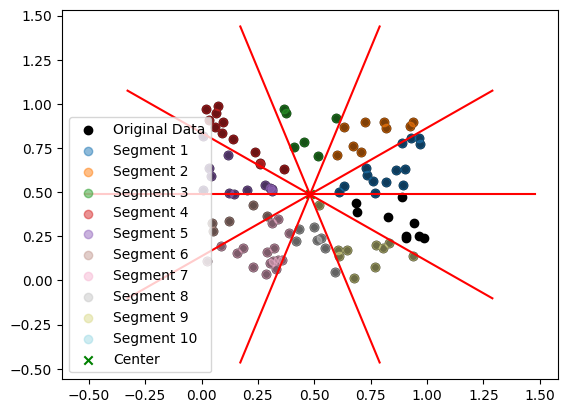

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Generate random data for demonstration
np.random.seed(42)
num_points = 100
data_list = [[np.random.rand(), np.random.rand()] for _ in range(num_points)]

# Convert the nested list to a numpy array
data_array = np.array(data_list)

# Calculate center
center = np.mean(data_array, axis=0)

# Calculate angles (starting from x-axis)
angles = np.arctan2(data_array[:, 1] - center[1], data_array[:, 0] - center[0])
angles = np.mod(angles, 2 * np.pi)  # Normalize to [0, 2*pi]
sorted_indices = np.argsort(angles)
angles = angles[sorted_indices]

# Create lines
num_segments = 10
segment_angles = np.linspace(0, 2 * np.pi, num_segments, endpoint=False)
segment_lines = [(center[0], center[1], np.cos(a), np.sin(a)) for a in segment_angles]

# Determine points inside segments
points_inside_segments = [sorted_indices[(angles >= a1) & (angles < a2)] for a1, a2 in zip(segment_angles, np.roll(segment_angles, -1))]

# Generate a colormap with distinct colors for segments
segment_colors = plt.cm.get_cmap('tab20', num_segments)

# Visualization
data_array_x = data_array[:, 0]
data_array_y = data_array[:, 1]

plt.scatter(data_array_x, data_array_y, c='black', label='Original Data')
for i, line in enumerate(segment_lines):
    plt.plot([line[0], line[0] + line[2]], [line[1], line[1] + line[3]], color='r')

    # Scatter plot with points inside segments colored based on the segment
    segment_color = segment_colors(i)
    plt.scatter(data_array_x[points_inside_segments[i]], data_array_y[points_inside_segments[i]], color=segment_color, label=f'Segment {i+1}', alpha=0.5)

plt.scatter(center[0], center[1], color='g', marker='x', label='Center')
plt.legend()
plt.show()

/var/folders/9l/npp_6cfd1_3ff1p57ff14rfh0000gn/T/ipykernel_2992/3687405644.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  segment_colors = plt.cm.get_cmap('tab20', num_segments)


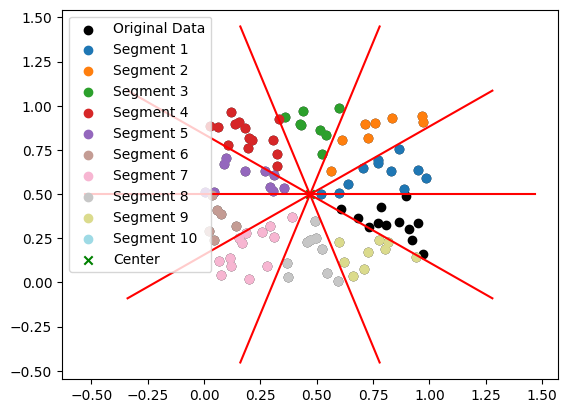

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Generate random data for demonstration
np.random.seed(42)
num_points = 100
x = np.random.rand(num_points)
y = np.random.rand(num_points)

# Calculate center
center = np.mean(x), np.mean(y)

# Calculate angles (starting from x-axis)
angles = np.arctan2(y - center[1], x - center[0])
angles = np.mod(angles, 2 * np.pi)  # Normalize to [0, 2*pi]
sorted_indices = np.argsort(angles)
angles = angles[sorted_indices]

# Create lines
num_segments = 10
segment_angles = np.linspace(0, 2 * np.pi, num_segments, endpoint=False)
segment_lines = [(center[0], center[1], np.cos(a), np.sin(a)) for a in segment_angles]

# Determine points inside segments
points_inside_segments = [sorted_indices[(angles >= a1) & (angles < a2)] for a1, a2 in zip(segment_angles, np.roll(segment_angles, -1))]

# Generate a colormap with distinct colors for segments
segment_colors = plt.cm.get_cmap('tab20', num_segments)

# Visualization
plt.scatter(x, y, c='black', label='Original Data')
for i, line in enumerate(segment_lines):
    plt.plot([line[0], line[0] + line[2]], [line[1], line[1] + line[3]], color='r')

    # Scatter plot with points inside segments colored based on the segment
    segment_color = segment_colors(i)
    plt.scatter(x[points_inside_segments[i]], y[points_inside_segments[i]], color=segment_color, label=f'Segment {i+1}')

plt.scatter(center[0], center[1], color='g', marker='x', label='Center')
plt.legend()
plt.show()


In [10]:
pca_components[0]

array([124.43006766, -24.93818981])